In [3]:
from pathlib import Path

import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [38]:
data_folder = Path("data/resstock")
version = "USA_2024_04_27_transformer_test_00"
run_suffix = "infiltration_and_pd_expanded_5"
baesline_state = 0
upgrade_state = 2


####
results_folder = data_folder / "results" / version
county_folder = results_folder / "counties"
baseline_folder = county_folder / f"upgrade_{baesline_state}" / run_suffix
upgrade_folder = county_folder / f"upgrade_{upgrade_state}" / run_suffix
baseline_files = list(baseline_folder.glob("*.hdf"))
upgrade_files = list(upgrade_folder.glob("*.hdf"))
baseline_dfs = [pd.read_hdf(file, "preds_and_true") for file in baseline_files]
upgrade_dfs = [pd.read_hdf(file, "preds_and_true") for file in upgrade_files]
baseline_run_counties = [
    file.stem[file.stem.index("G") : file.stem.index("G") + 7]
    for file in baseline_files
]
upgrade_run_counties = [
    file.stem[file.stem.index("G") : file.stem.index("G") + 7] for file in upgrade_files
]
baseline_dfs = pd.concat(
    baseline_dfs, keys=baseline_run_counties, names=["county"], axis=0
)
upgrade_dfs = pd.concat(
    upgrade_dfs, keys=upgrade_run_counties, names=["county"], axis=0
)
baseline_dfs.columns.names = ["segment", "end_use", "month"]
upgrade_dfs.columns.names = ["segment", "end_use", "month"]

available_buildings = list(
    set(baseline_dfs.index.get_level_values("building_id").unique())
    & set(upgrade_dfs.index.get_level_values("building_id").unique())
)

baseline_mask = baseline_dfs.index.get_level_values("building_id").isin(
    available_buildings
)
upgrade_mask = upgrade_dfs.index.get_level_values("building_id").isin(
    available_buildings
)
baseline = baseline_dfs.loc[baseline_mask]
upgrade = upgrade_dfs.loc[upgrade_mask]
baseline: pd.DataFrame = baseline.sort_index(level=["county", "building_id"])
upgrade: pd.DataFrame = upgrade.sort_index(level=["county", "building_id"])
assert (
    baseline.index.get_level_values("building_id")
    == upgrade.index.get_level_values("building_id")
).all()
upgrade_features = upgrade.index.to_frame(index=False)
upgrade.index = baseline.index
# res_b = baseline["Predicted"] - baseline["True"]
# baseline["Residual"] = 0
# baseline.loc[:, ("Residual", slice(None), slice(None))] = res_b
# res_u = upgrade["Predicted"] - upgrade["True"]
# upgrade["Residual"] = 0
# upgrade.loc[:, ("Residual", slice(None), slice(None))] = res_u
df = pd.concat(
    [baseline, upgrade],
    keys=["baseline", "upgrade"],
    names=["run"],
    axis=1,
)

In [39]:
# df.to_hdf("baseline_and_upgrade.hdf", key="baseline_and_upgrades", mode="w")
# upgrade_features.to_hdf("baseline_and_upgrade.hdf", key="upgrade_features", mode="a")

In [33]:
areas = df.index.get_level_values("area").values.reshape(-1, 1)
savings = (df["baseline"] - df["upgrade"]) * areas

filtered_df = df.loc[
    df.index.get_level_values("climate_zone").isin(
        ["5A", "5B", "5C", "6A", "6B", "7A", "7B", "8A", "8B", "7", "8"]
    )
]
annual_savings_demand = savings.T.groupby(["segment", "end_use"]).sum().T
annual_savings_demand.columns = annual_savings_demand.columns.map("_".join)


annual_baseline_eui = (
    (filtered_df["baseline"]).T.groupby(["segment", "end_use"]).sum().T
)
annual_baseline_eui.columns = annual_baseline_eui.columns.map("_".join)
monthly_baseline_eui = filtered_df["baseline"].stack(level="month")
monthly_baseline_eui.columns = monthly_baseline_eui.columns.map("_".join)

annual_upgrade_eui = (filtered_df["upgrade"]).T.groupby(["segment", "end_use"]).sum().T
annual_upgrade_eui.columns = annual_upgrade_eui.columns.map("_".join)

monthly_upgrade_eui = filtered_df["upgrade"].stack(level="month")
monthly_upgrade_eui.columns = monthly_upgrade_eui.columns.map("_".join)
annual_upgrade_eui = (filtered_df["upgrade"]).T.groupby(["segment", "end_use"]).sum().T
annual_upgrade_eui.columns = annual_upgrade_eui.columns.map("_".join)

monthly_savings_eui = (filtered_df["baseline"] - filtered_df["upgrade"]).stack(
    level="month"
)
monthly_savings_eui.columns = monthly_savings_eui.columns.map("_".join)
annual_savings_eui = (
    (filtered_df["baseline"] - filtered_df["upgrade"])
    .T.groupby(["segment", "end_use"])
    .sum()
    .T
)
annual_savings_eui.columns = annual_savings_eui.columns.map("_".join)
annual_savings_eui_percent = annual_savings_eui / annual_baseline_eui * 100

C:\Users\szvsw\AppData\Local\Temp\ipykernel_17488\4084180832.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


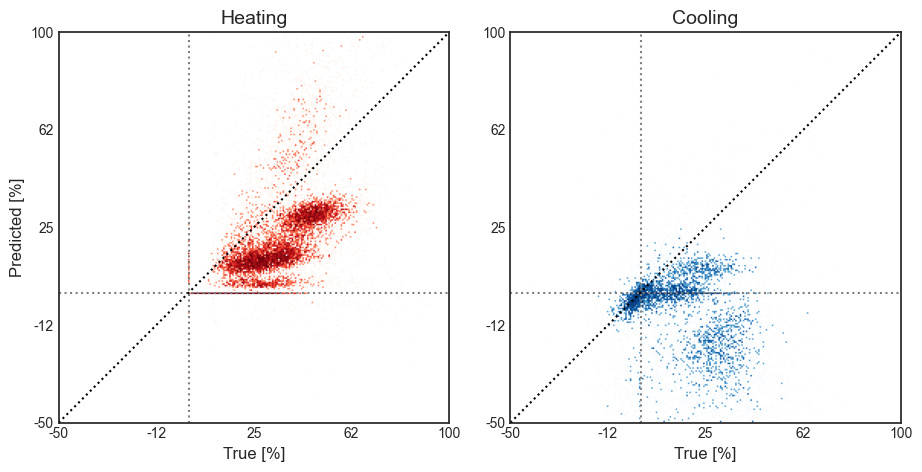

In [37]:
save = False
from matplotlib import cm

# plt.style.use("dark_background")
# plt.style.use("default")
plt.style.use("seaborn-white")

plt.rcParams["font.family"] = "sans serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams["axes.titleweight"] = "light"
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["figure.subplot.bottom"] = 0.4

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
bg_color, cmap, hmap = "#ffffff", cm.Blues, cm.Reds
# bg_color, cmap = "#ffffff", cc.bgy
fig.patch.set_facecolor(bg_color)

# create a datashader canvas
plot_df, res, limfactor = monthly_baseline_eui, 512, 0.35
plot_df, res, limfactor = annual_baseline_eui, 256, 0.35
plot_df, res, limfactor = monthly_upgrade_eui, 512, 0.35
plot_df, res, limfactor = annual_upgrade_eui, 256, 0.35
plot_df, res, limlow, limhigh, units = monthly_savings_eui, 512, -5, 15, "kWh/m2"
plot_df, res, limlow, limhigh, units = annual_savings_eui, 512, -20, 100, "kWh/m2"
plot_df, res, limlow, limhigh, units = annual_savings_eui_percent, 256, -50, 100, "%"
limits = plot_df.max().max() * limfactor
lims = (limlow, limhigh)

cvs = ds.Canvas(
    plot_width=res,
    plot_height=res,
    x_range=lims,
    y_range=lims,
)
# create a scatterplot of the data
i = 0
for end_use in ["Heating", "Cooling"]:

    agg = cvs.points(plot_df, (f"True_{end_use}"), (f"Predicted_{end_use}"))
    shader = ds.tf.shade(agg, cmap=cmap if end_use == "Cooling" else hmap)
    # create a line from 0,0 to max of df[true_{end_use}]
    # line = pd.DataFrame({"x":[0, df[f"true_{end_use}"].max()], "y":[0, df[f"true_{end_use}"].max()]})
    # line_agg = cvs.line(line, "x","y")
    # shade the line
    # line_shader = ds.tf.shade(line_agg, cmap="white")
    # stack the line on top of the scatterplot
    # shader = ds.tf.stack(shader, line_shader)
    im = ds.tf.set_background(shader, bg_color, f"{end_use}")
    im = im.to_pil()
    if save:
        im.save(f"figures/true_vs_preds_{end_use}_res.png")
    # plot im upside down
    axs[i].imshow(np.flipud(im), origin="lower")
    axs[i].set_title(f"{end_use}")
    if limlow < 0:
        # compute the coordinate of the 0,0 point in the plot
        x0 = res * (0 - limlow) / (limhigh - limlow)
        y0 = res * (0 - limlow) / (limhigh - limlow)
        # plot the 0,0 line
        axs[i].plot(
            [0, res], [y0, y0], ":", color="white" if bg_color != "#ffffff" else "gray"
        )
        axs[i].plot(
            [x0, x0], [0, res], ":", color="white" if bg_color != "#ffffff" else "gray"
        )
    axs[i].plot(
        [0, res], [0, res], ":", color="white" if bg_color != "#ffffff" else "black"
    )
    i += 1
# i = i + 1
for i in range(2):
    axs[i].set_xticks(
        np.linspace(0, res, 5).astype(int), np.linspace(limlow, limhigh, 5).astype(int)
    )
    axs[i].set_yticks(
        np.linspace(0, res, 5).astype(int), np.linspace(limlow, limhigh, 5).astype(int)
    )
    if i == 0:
        axs[i].set_ylabel(f"Predicted [{units}]")
    axs[i].set_xlabel(f"True [{units}]")
    axs[i].set_xlim(0, res)
    axs[i].set_ylim(0, res)
# fig.suptitle(
#     f"Monthly EUI Model Fit (n={int(len(df)/12//100_000 * 100_000):,d} buildings)"
# )
# plt.suptitle("Baseline ResStock Annual Demand")
fig.tight_layout()

In [52]:
areas

array([[114.01869159],
       [114.01869159],
       [157.94392523],
       ...,
       [114.01869159],
       [203.36448598],
       [114.01869159]])

In [75]:
# area
areas_by_county = (
    df.index.to_frame()["area"].groupby(["climate_zone", "state", "county"]).sum()
)
areas_by_state = df.index.to_frame()["area"].groupby("state").sum()
areas_by_climate_zone = df.index.to_frame()["area"].groupby("climate_zone").sum()

# energy
total_energy = df * areas
energy_by_county = (
    total_energy.groupby(["climate_zone", "state", "county"])
    .sum()
    .T.groupby(["run", "segment", "end_use"])
    .sum()
    .T
)
energy_by_state = (
    total_energy.groupby("state").sum().T.groupby(["run", "segment", "end_use"]).sum().T
)
energy_by_climate_zone = (
    total_energy.groupby("climate_zone")
    .sum()
    .T.groupby(["run", "segment", "end_use"])
    .sum()
    .T
)
energy_by_nation = total_energy.T.groupby(["run", "segment", "end_use"]).sum().T.sum()
#
eui_by_county = energy_by_county / areas_by_county.values.reshape(-1, 1)
eui_by_state = energy_by_state / areas_by_state.values.reshape(-1, 1)

# savings
savings_by_county = energy_by_county["baseline"] - energy_by_county["upgrade"]
savings_by_state = energy_by_state["baseline"] - energy_by_state["upgrade"]
savings_by_climate_zone = (
    energy_by_climate_zone["baseline"] - energy_by_climate_zone["upgrade"]
)
savings_by_nation = energy_by_nation["baseline"] - energy_by_nation["upgrade"]

# percent savings
percent_savings_by_county = savings_by_county / energy_by_county["baseline"] * 100
percent_savings_by_state = savings_by_state / energy_by_state["baseline"] * 100
percent_savings_by_climate_zone = (
    savings_by_climate_zone / energy_by_climate_zone["baseline"] * 100
)
percent_savings_by_nation = savings_by_nation / energy_by_nation["baseline"] * 100

segment                     Predicted                  True           
end_use                       Cooling    Heating    Cooling    Heating
climate_zone state county                                             
1A           FL    G120011   4.192979  25.082859  14.255314  52.309042
                   G120086   4.189250  29.426537  16.471360  61.405677
                   G120087   6.274734  30.073632  15.486961  53.197432
2A           AL    G010097   4.649806  22.607507  19.189873  43.993661
             FL    G120099   2.584427  26.488715  14.968186  49.333495
...                               ...        ...        ...        ...
7A           MN    G270137 -19.590855   9.800938  10.619442  25.990588
             ND    G380017  -6.427631   8.385060  10.608396  23.378221
7B           CO    G080049  -3.629084   1.732378   3.731135  14.102191
                   G080107  -6.902148   7.284927  16.642498  19.784062
                   G080117 -19.863210   5.801369  -9.585119  20.371759

[114 rows x 4 columns]

In [76]:
import plotly.express as px

px.bar(
    percent_savings_by_climate_zone.melt(
        ignore_index=False, value_name="% Savings"
    ).reset_index(),
    x="climate_zone",
    y="% Savings",
    color="segment",
    barmode="group",
    facet_col="end_use",
)

In [87]:
percent_savings_by_county

segment                     Predicted                  True           
end_use                       Cooling    Heating    Cooling    Heating
climate_zone state county                                             
1A           FL    G120011   4.192979  25.082859  14.255314  52.309042
                   G120086   4.189250  29.426537  16.471360  61.405677
                   G120087   6.274734  30.073632  15.486961  53.197432
2A           AL    G010097   4.649806  22.607507  19.189873  43.993661
             FL    G120099   2.584427  26.488715  14.968186  49.333495
...                               ...        ...        ...        ...
7A           MN    G270137 -19.590855   9.800938  10.619442  25.990588
             ND    G380017  -6.427631   8.385060  10.608396  23.378221
7B           CO    G080049  -3.629084   1.732378   3.731135  14.102191
                   G080107  -6.902148   7.284927  16.642498  19.784062
                   G080117 -19.863210   5.801369  -9.585119  20.371759

[114 rows x 4 columns]